<img src="https://ethical-principles-in-ai.github.io/static/media/epai_logo.e502dc0cef3c434c1abf.png" width="100">

# Deep Learning with Differential Privacy: Base Model

This model provides a baseline for comparison between various differential privacy techniques. It uses the DP-SGD techqniue, as described in [Abadi et al.](https://arxiv.org/abs/1607.00133). Guassian noise is applied within SGD to ensure the model cannot be reverse engineered using inputs/outputs, which makes the model differientially private.

*Written by Nicole Streltsov February 2023*

In [1]:
# imports
!pip --quiet install  objax
import objax # to define a custom model with more control
import tensorflow as tf 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jn
import jax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 KB 703.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Data, Model Creation, and Function Definitions

In [2]:
# load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # dataset of 60000 32x32 coloured images
x = np.concatenate([x_train, x_test], axis = 0)
y = np.concatenate([y_train, y_test], axis = 0)

# shuffle
x, y = shuffle(x, y, random_state=0)

# split into 80% train, 10% valid, 10% test
x_train, x_remaining, y_train, y_remaining = train_test_split(x, y, train_size=0.8)
x_valid, x_test, y_valid, y_test = train_test_split(x_remaining, y_remaining, test_size=0.5) # split remaining 20% into 10% and 10%

#convert to proper format
def convert_x(x):
  return x.transpose(0, 3, 1, 2) / 255.0 # normalize, and ensure correct indicies for model

x_train = convert_x(x_train)
y_train = y_train.flatten()

x_valid = convert_x(x_valid)
y_valid = y_valid.flatten()

x_test = convert_x(x_test)
y_test = y_test.flatten()

170498071/170498071 [==============================] - 2s 0us/step


In [3]:
# define cnn
class CNN(objax.Module):
  def __init__(self, channels = 3, classes = 10):
    self.conv1 = objax.nn.Sequential([objax.nn.Conv2D(channels, 16, 2), objax.functional.relu])
    self.conv2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.fc1 = objax.nn.Linear(32, classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv1(x), 2, 2)
    x = self.conv2(x)
    x = x.mean((2,3)) #global average pooling 
    x = self.fc1(x)
    return x

<Figure size 432x288 with 0 Axes>

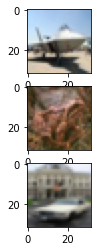

In [4]:
# show preview of dataset images
plt.figure()
f, axarr = plt.subplots(3,1) 
axarr[0].imshow(x_train[0].transpose(1,2,0))
axarr[1].imshow(x_valid[0].transpose(1,2,0))
axarr[2].imshow(x_test[0].transpose(1,2,0))

In [5]:
#training loop helper function
def train_per_batch(x, y, lr, batch, train_op, predict):
  acc = 0
  shuffle_indicies = np.arange(len(x))
  np.random.shuffle(shuffle_indicies) #shuffle before running batches to remove correlation

  for i in range(0, x.shape[0], batch):
      batch_idxs = shuffle_indicies[i:i+batch]

      #run train_op step
      loss = float(train_op(x[batch_idxs], y[batch_idxs], lr)[0]) * len(batch_idxs)
      
      #store accuracy
      acc += (np.array(predict(x[batch_idxs]).argmax(1)).flatten() == y[batch_idxs]).sum()

  return acc

#training loop
def train(epochs, batch, lr, x_train, x_valid, y_train, y_valid, train_op, predict):
  train_accuracies = []
  valid_accuracies = []

  for epoch in range(1, epochs+1):
      train_loss = []
      valid_loss = []

      # batch training
      avg_train_acc = train_per_batch(x_train, y_train, lr, batch, train_op, predict) / x_train.shape[0]
      train_accuracies.append(avg_train_acc)
      
      # batch validation 
      avg_val_acc = train_per_batch(x_valid, y_valid, lr, batch, train_op, predict) / x_valid.shape[0]
      valid_accuracies.append(avg_val_acc)

      print('Epoch %d  Training Accuracy %.4f Validation Accuracy %.4f' % (epoch, avg_train_acc*100, avg_val_acc*100))
    
  return train_accuracies, valid_accuracies

## Train Regular CNN

In [ ]:
# hyperparameters
epochs = 100
batch = 100
lr = 0.1

In [ ]:
#define model
model_regular = CNN(channels = 3, classes = 10)

#define loss
def loss_fn_regular(x, y):
    return objax.functional.loss.cross_entropy_logits_sparse(model_regular(x), y).mean()

#define prediction function (to get results of model training)
predict_regular = objax.Jit(lambda x: objax.functional.softmax(model_regular(x)), model_regular.vars())

# define 'forward' operation.
gv_regular = objax.GradValues(loss_fn_regular, model_regular.vars()) #function that calculates gradient
tv_regular = objax.ModuleList(objax.TrainRef(x) for x in model_regular.vars().subset(objax.TrainVar)) #trainable variables

def train_op_regular(x, y, lr):
    g, v = gv_regular(x, y) # apply gradient
    
    # ** optimzer: SGD **
    for grad, params in zip(g, tv_regular.vars()):
      params.value -= jn.multiply(grad, lr) #jax speeds up computation

    return v # v is the loss

train_op_regular = objax.Jit(train_op_regular, gv_regular.vars() + tv_regular.vars()) # compile train_op to make it faster

In [ ]:
# train without differential privacy (dp)
train_accuracies_regular, valid_accuracies_regular = train(epochs, batch, lr, x_train, x_valid, y_train, y_valid, train_op_regular, predict_regular)

Epoch 1  Training Accuracy 21.27 Validation Accuracy 24.45
Epoch 2  Training Accuracy 25.45 Validation Accuracy 28.07
Epoch 3  Training Accuracy 28.39 Validation Accuracy 29.58
Epoch 4  Training Accuracy 30.08 Validation Accuracy 31.55
Epoch 5  Training Accuracy 31.43 Validation Accuracy 33.68
Epoch 6  Training Accuracy 33.10 Validation Accuracy 34.65
Epoch 7  Training Accuracy 34.48 Validation Accuracy 34.47
Epoch 8  Training Accuracy 35.61 Validation Accuracy 37.52
Epoch 9  Training Accuracy 36.50 Validation Accuracy 38.30
Epoch 10  Training Accuracy 38.04 Validation Accuracy 38.90
Epoch 11  Training Accuracy 39.28 Validation Accuracy 39.50
Epoch 12  Training Accuracy 40.20 Validation Accuracy 41.65
Epoch 13  Training Accuracy 41.44 Validation Accuracy 42.48
Epoch 14  Training Accuracy 42.75 Validation Accuracy 43.68
Epoch 15  Training Accuracy 43.67 Validation Accuracy 44.88
Epoch 16  Training Accuracy 44.75 Validation Accuracy 45.53
Epoch 17  Training Accuracy 45.64 Validation Accu

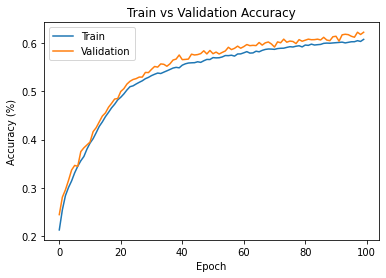

In [ ]:
plt.title("Training and Validation Accuracies of Regular CNN")
plt.plot(train_accuracies_regular, label="Train")
plt.plot(valid_accuracies_regular, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

In [ ]:
test_accuracy_regular = (np.array(predict_regular(x_test).argmax(1)).flatten() == y_test).sum()
print("Test Accuracy of Regular Model: ", 100*test_accuracy_regular/x_test.shape[0])

Test Accuracy of Regular Model:  56.18333333333333


## Train CNN with Differential Privacy

In train_op_dp, add gaussian noise and gradient clipping


In [88]:
# hyperparameters
epochs = 100
batch = 100
lr = 0.1
sigma = 4 # noise scale
C = 300 # gradient norm (Best C = median of the norms of the unclipped gradients) - mean was 299.5 after running with C=100
L = int(np.sqrt(len(x))) # L = √ N is the best group size

In [89]:
#define model
model_dp = CNN(channels = 3, classes = 10)

#define loss
def loss_fn_dp(x, y):
    return objax.functional.loss.cross_entropy_logits_sparse(model_dp(x), y).mean()

#define prediction function (to get results of model training)
predict_dp = objax.Jit(lambda x: objax.functional.softmax(model_dp(x)), model_dp.vars())

# define 'forward' operation.
gv_dp = objax.GradValues(loss_fn_dp, model_dp.vars()) #dictionary that stores gradients
tv_dp = objax.ModuleList(objax.TrainRef(x) for x in model_dp.vars().subset(objax.TrainVar)) #trainable variables
unclipped_grad = jn.arange(len(tv_dp.vars())*epochs) #store in list, to find best C

def train_op_dp(x, y, lr):
    g, v = gv_dp(x, y) # apply gradient

    # ** optimzer: DP-SGD **

    i = 0 # which model variable
    for grad, params in zip(g, tv_dp.vars()):

      # get random "lot (L)" of examples to add noise to:
      lot_idxs = np.random.choice(len(x), L)
      g_lot, __ = gv_dp(x[lot_idxs], y[lot_idxs]) #get grad only for lot
      grad = g_lot[i]
    
      #gradient clipping
      norm = jn.linalg.norm(grad)
      unclipped_grad.at[i].set(norm) #store unlcipped gradients
      grad_clipped = grad / jn.maximum(jn.empty(jn.shape(norm)) + 1, norm/C)

      #apply guassian
      mu = 0
      std = sigma*C
      key = jax.random.PRNGKey(0) # to ensure guassian stays the same for all runs
      guassian = mu + std * jax.random.normal(key, jn.shape(grad_clipped))
      grad_w_guassian = jn.multiply(1/L, jn.add(grad_clipped, guassian))
      
      #update params
      params.value -= jn.multiply(grad_clipped, lr) 

      i+=1

    return v # v is the loss

train_op_dp = objax.Jit(train_op_dp, gv_dp.vars() + tv_dp.vars()) # compile train_op to make it faste

In [90]:
# train with differential privacy
train_accuracies_dp, valid_accuracies_dp = train(epochs, batch, lr, x_train, x_valid, y_train, y_valid, train_op_dp, predict_dp)

print ("---- For hyperparameter tuning: ----")
print("mean of unclipped gradients -> ", jn.mean(unclipped_grad))

Epoch 1  Training Accuracy 20.6167 Validation Accuracy 23.0000
Epoch 2  Training Accuracy 26.2208 Validation Accuracy 26.8667
Epoch 3  Training Accuracy 30.2958 Validation Accuracy 31.0833
Epoch 4  Training Accuracy 32.0229 Validation Accuracy 32.0000
Epoch 5  Training Accuracy 32.8000 Validation Accuracy 32.8500
Epoch 6  Training Accuracy 34.6167 Validation Accuracy 31.1500
Epoch 7  Training Accuracy 35.6625 Validation Accuracy 36.2667
Epoch 8  Training Accuracy 36.9854 Validation Accuracy 36.8000
Epoch 9  Training Accuracy 37.6042 Validation Accuracy 37.5333
Epoch 10  Training Accuracy 38.8000 Validation Accuracy 38.7667
Epoch 11  Training Accuracy 39.6604 Validation Accuracy 39.8167
Epoch 12  Training Accuracy 40.8229 Validation Accuracy 40.5500
Epoch 13  Training Accuracy 41.8958 Validation Accuracy 41.3167
Epoch 14  Training Accuracy 42.6667 Validation Accuracy 43.2667
Epoch 15  Training Accuracy 43.9125 Validation Accuracy 44.3000
Epoch 16  Training Accuracy 44.5938 Validation Ac

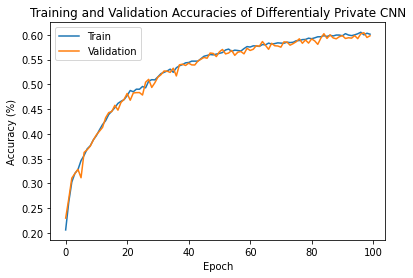

In [91]:
plt.title("Training and Validation Accuracies of Differentialy Private CNN")
plt.plot(train_accuracies_dp, label="Train")
plt.plot(valid_accuracies_dp, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

In [92]:
test_accuracy_dp = (np.array(predict_dp(x_test).argmax(1)).flatten() == y_test).sum()
print("Test Accuracy of Regular Model: ", 100*test_accuracy_dp/x_test.shape[0])

Test Accuracy of Regular Model:  55.86666666666667
